In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import discretize
from scipy import sparse as sp
from scipy.constants import mu_0

from pymatsolver import Pardiso

# we are in the midst of upgrading the API, so this is 
# more closely in-line with the upcoming changes
from SimPEG.EM import TDEM as tdem

%matplotlib inline

# create a mesh

In [2]:
ncx = 20
csx = 0.5
npadx = 30

csz = 10
ncz = 100
npadz = 20

pf = 1.3

mesh = discretize.CylMesh([
    [(csx, ncx), (csx, npadx, pf)],  # x discretization 
    np.r_[2*np.pi],   # theta discretization
    [(csz, npadz, -pf), (csz, ncz), (csz, npadz, pf)]  # z discretization
])

mesh.x0 = np.r_[0., 0., -mesh.hz[:npadz+ncz].sum()]

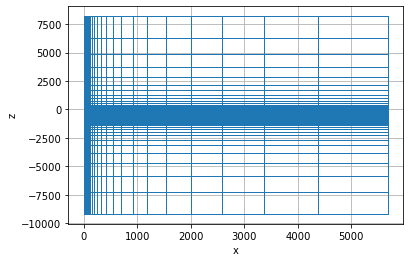

In [3]:
mesh.plotGrid()

## create a model

In [4]:
sigma_air = 1e-8
sigma_background = 1e-2
sigma_casing = 1e4
r_casing = 2.
z_casing = np.r_[-1000, 0]

m = sigma_air * np.ones(mesh.nC)
m[mesh.gridCC[:, 2] < 0] = sigma_background

inds_casing = (
    (mesh.gridCC[:, 0] <= r_casing) & 
    (mesh.gridCC[:, 2] >= z_casing.min()) & 
    (mesh.gridCC[:, 2] <= z_casing.max())
)
m[inds_casing] = sigma_casing


# time stepping
dt = np.logspace(-6, -2, 50)
times = np.cumsum(dt)

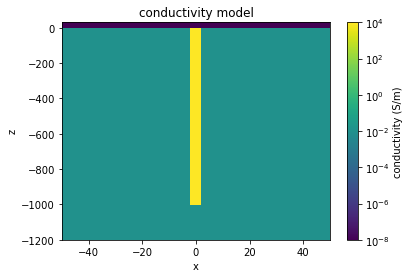

In [5]:
fig, ax = plt.subplots(1, 1)
out = mesh.plotImage(m, mirror=True, pcolorOpts={"norm":LogNorm()}, ax=ax)
cb = plt.colorbar(out[0])
ax.set_xlim(50*np.r_[-1, 1])
ax.set_ylim(np.r_[-1200, 30])
ax.set_title("conductivity model")
cb.set_label("conductivity (S/m)")

## create a source function 
- this is a simplified, rough approximation of what we expect the source term to look like for the correction 
- here we set up a magnetic source (which lives on cell-edges)
- assume the electric source is zero
- the initial contition is that j = 0 everywhere

In [6]:
def waveform(t, t_peak=5e-3, width=10, amplitude=1):
    t = np.log10(t)
    t_peak = np.log10(t_peak)
    width = np.log10(width)
    return amplitude * np.exp(-(t - t_peak)**2/(2*width**2))

def sigmoid(x, x0=0, slope=1):
    return np.arctan(slope * (x-x0))/np.pi + 0.5

def depth_distribution(z, dz=100, slope=1e-1):
    return sigmoid(z, z_casing.min() + dz, slope) * sigmoid(-z, -(z_casing.max() - dz), slope)

Text(0.5, 0, 't')

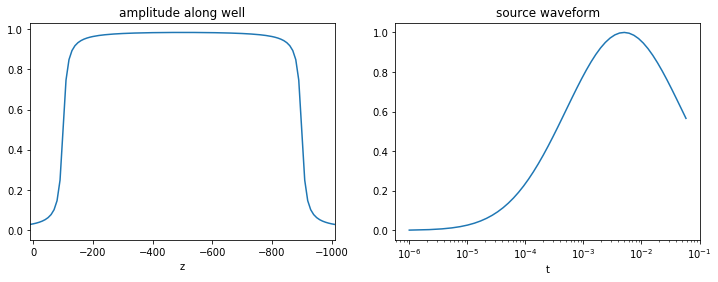

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(mesh.vectorNz, depth_distribution(mesh.vectorNz))
ax[0].set_xlim([10, -1010])
ax[0].set_title("amplitude along well")
ax[0].set_xlabel("z")

ax[1].semilogx(
    times, 
    waveform(times, t_peak=5e-3, width=10) 
)
ax[1].set_title("source waveform")
ax[1].set_xlabel("t")

### put the source on the mesh

In [8]:
def source_sm(mesh, t):
    sm = np.zeros(mesh.nE)
    
    # edge just outside the casing
    xinds = (mesh.gridEy[:, 0] < r_casing + csx/2) & (mesh.gridEy[:, 0] > r_casing - csx/2)

    sm[xinds] = waveform(t) * depth_distribution(mesh.gridEy[xinds, 2])
    
    return sm

## set up and run the forward simulation

This is implemented in the SimPEG EM module for general use, but to play with the pieces, I have copied the code over (and simplified as we don't have an electric source for this problem). 

In [13]:
def getA(mesh, time_steps, sigma, time_ind, make_symmetric=True):
    dt = time_steps[time_ind]
    C = mesh.edgeCurl
    MfRho = mesh.getFaceInnerProduct(1./sigma)
    MeMuI = mesh.getEdgeInnerProduct(mu_0, invMat=True)
    eye = sp.eye(mesh.nF)

    A = C * (MeMuI * (C.T * MfRho)) + 1./dt * eye
    
    if make_symmetric is True:
        A = MfRho.T * A
    
    return A
    
def getAsubdiag(mesh, time_steps, sigma, time_ind, make_symmetric=True):
    eye = sp.eye(mesh.nF)
    dt = time_steps[time_ind]

    if make_symmetric:
        MfRho = mesh.getFaceInnerProduct(1./sigma)
        return -1./dt * MfRho.T
    return -1./dt * eye
        
def getRHS(mesh, time_steps, sigma, time_ind, make_symmetric=True):
    C = mesh.edgeCurl
    MeMuI = mesh.getEdgeInnerProduct(mu_0, invMat=True)
    dt = time_steps[time_ind]

    # full source term 
    # rhs = -1./dt * (s_e - s_en1) + C * MeMuI * s_m
    
    # we are setting s_e to zero
    rhs = C * MeMuI * source_sm(mesh, np.cumsum(time_steps)[time_ind])
    
    if make_symmetric:
        MfRho = mesh.getFaceInnerProduct(1./sigma)
        return MfRho.T * rhs
    return rhs

In [14]:
def increment_j(jn1, mesh, time_steps, sigma, time_ind, make_symmetric=True):
    if time_ind == 0:
        raise Exception("time ind must be greater than zero")
    A = getA(mesh, time_steps, sigma, time_ind, make_symmetric)
    An1 = getAsubdiag(mesh, time_steps, sigma, time_ind, make_symmetric)
    rhs = getRHS(mesh, time_steps, sigma, time_ind, make_symmetric)
    
    Ainv = Pardiso(A)  # creates an object that acts like A inverse 
    
    return Ainv * (rhs - An1 * jn1)

In [15]:
%%time
j = np.zeros((mesh.nF, len(times)))

for i in range(1, len(times)):
    j[:, i] = increment_j(j[:, i-1], mesh, dt, m, i)

CPU times: user 9.89 s, sys: 651 ms, total: 10.5 s
Wall time: 2.69 s


Text(0.5, 1.0, 'current density, t=1.6e+00ms')

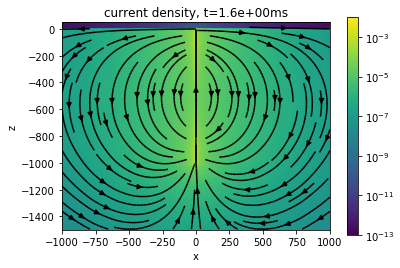

In [16]:
tind = 30
fig, ax = plt.subplots(1, 1)

out = mesh.plotImage(
    mesh.aveF2CCV * j[:, tind], 
    view="vec",
    vType="CCv",
    ax=ax, mirror=True,
    range_x=np.r_[-1000, 1000], 
    range_y=np.r_[-1500, 50],
    pcolorOpts={"norm":LogNorm()},
    clim = np.r_[1e-13, 1e-2], 
    stream_threshold = 1e-13
)
ax.set_aspect(1)
plt.colorbar(out[0])

ax.set_title(f"current density, t={times[tind]*1e3:1.1e}ms")